# CNN 과제 - 이지원

## 필요한 라이브러리 import

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.model_selection import train_test_split

## 랜덤 시드 고정

- Random Seed를 고정하여 재현성을 보장

In [2]:
import random
import numpy as np

def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(1234)

## GPU 가용성 확인 및 연산 장치 결정

In [3]:
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

CUDA Available: True
Current Device: cuda


## Dataset Class 정의

- 데이터 파일이 없을 경우 자동으로 다운로드 수행

In [4]:
import typing
import os
import tarfile
import numpy as np
from PIL import Image
from urllib.request import urlretrieve
from tqdm import tqdm


class OxfordIIITPetDataset(torch.utils.data.Dataset):
  def __init__(self, root: str = "./data", split: str = "trainval", download: bool = True, transform: typing.Callable | None = None):
    self.root = root
    self.split = split
    self.transform = transform

    self.url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    self.annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
    self.image_folder = os.path.join(self.root, "images")
    self.annotations_folder = os.path.join(self.root, "annotations")

    if download:
      self._download()

    self.data = self._load_data()

  def _download(self):
    os.makedirs(self.root, exist_ok=True)

    image_tar_path = os.path.join(self.root, "images.tar.gz")
    annotations_tar_path = os.path.join(self.root, "annotations.tar.gz")

    if not os.path.exists(self.image_folder):
      print("Downloading images...")
      self._download_with_progress(self.url, image_tar_path)
      print("Extracting images...")
      with tarfile.open(image_tar_path, "r:gz") as tar:
        tar.extractall(path=self.root)

    if not os.path.exists(self.annotations_folder):
      print("Downloading annotations...")
      self._download_with_progress(self.annotations_url, annotations_tar_path)
      print("Extracting annotations...")
      with tarfile.open(annotations_tar_path, "r:gz") as tar:
        tar.extractall(path=self.root)

  def _download_with_progress(self, url: str, file_path: str):
    with tqdm(total=None, unit="B", unit_scale=True, desc="Downloading", dynamic_ncols=True) as progress_bar:
      def show_progress(block_num, block_size, total_size):
        if progress_bar.total != total_size:
          progress_bar.total = total_size
        progress_bar.update(block_size)

      urlretrieve(url, file_path, reporthook=show_progress)

  def _load_data(self):
    if self.split not in ("trainval", "test"):
      raise ValueError(self.split)

    split_file = os.path.join(self.annotations_folder, f"{self.split}.txt")
    if not os.path.exists(split_file):
      raise FileNotFoundError(split_file)

    data = []
    with open(split_file, "r") as f:
      for line in f:
        img_name, label = line.strip().split()[:2]
        img_path = os.path.join(self.image_folder, img_name + ".jpg")
        if os.path.exists(img_path):
          data.append((img_path, int(label) - 1))

    return data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path, label = self.data[idx]
    img = Image.open(img_path).convert("RGB")

    if self.transform:
      img = self.transform(img)

    return img, label

## 데이터셋 준비

- Train Dataset, Validation Dataset 4:1 분할
- Train Dataset에 Data Argumatation 적용

In [5]:
# train 데이터셋 준비
train_dataset = OxfordIIITPetDataset(
  root=".",
  split="trainval",
  download=True,
  transform=transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
  ])
)

train_indices, validation_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
validation_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)


# validation 데이터셋 준비
validation_dataset = OxfordIIITPetDataset(
  root=".",
  split="trainval",
  download=True,
  transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
  ])
)

# test 데이터셋 준비
test_dataset = OxfordIIITPetDataset(
  root=".",
  split="test",
  download=True,
  transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
  ])
)

print(f"Train 데이터 개수: {len(train_indices)}")
print(f"Validation 데이터 개수: {len(validation_indices)}")
print(f"Test 데이터 개수: {len(test_dataset)}")

Downloading: 792MB [00:44, 17.8MB/s]                           


Extracting images...


Downloading: 19.2MB [00:04, 3.90MB/s]                            


Extracting annotations...
Train 데이터 개수: 2944
Validation 데이터 개수: 736
Test 데이터 개수: 3669


## CNN 모델 정의

- BatchNorm을 사용하여 정규화
- Dropout을 사용하여 오버피팅 방지
- ReLU 활성화 함수를 사용
- Residual Block을 사용하여 Skip-Connection 구현

In [6]:
class ResidualBlock(nn.Module):
  def __init__(self, in_planes: int, planes: int, stride: int = 1, dropout: int | float | None = None):
    super().__init__()
    self.conv1 = nn.Conv2d(
      in_channels=in_planes,
      out_channels=planes,
      kernel_size=3,
      stride=stride,
      padding=1,
      bias=False
    )
    self.bn1 = nn.BatchNorm2d(num_features=planes)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(
      in_channels=planes,
      out_channels=planes,
      kernel_size=3,
      stride=1,
      padding=1,
      bias=False
    )
    self.bn2 = nn.BatchNorm2d(num_features=planes)
    self.act2 = nn.ReLU()

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
        nn.Conv2d(
          in_channels=in_planes,
          out_channels=planes,
          kernel_size=1,
          stride=stride,
          bias=False
        ),
        nn.BatchNorm2d(num_features=planes)
      )

    self.dropout = nn.Sequential() if dropout == None else nn.Dropout(dropout)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.act1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x)
    out = self.act2(out)
    out = self.dropout(out)
    return out


class Pool(nn.Module):
  def forward(self, x):
    input = nn.functional.adaptive_avg_pool2d(x, 1)
    return input.view(input.shape[0], -1)


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes):
    super().__init__()
    self.in_planes = 64
    self.conv1 = nn.Conv2d(
      in_channels=3,
      out_channels=64,
      kernel_size=3,
      stride=1,
      padding=1,
      bias=False
    )
    self.bn1 = nn.BatchNorm2d(num_features=64)
    self.act1 = nn.ReLU()
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout=0.2)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout=0.2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout=0.2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout=0.2)
    self.pool = Pool()
    self.linear = nn.Linear(512, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride, dropout: int | float | None = None):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride, dropout))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.act1(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.pool(out)
    out = self.linear(out)
    return out


def ResNet18(num_classes):
  return ResNet(block=ResidualBlock, num_blocks=[2, 2, 2, 2], num_classes=num_classes)

## 학습 함수 정의

- 각 Epoch마다 Validation Dataset에 대한 성능을 측정하여 Overfitting 여부 확인
- Early Stopping을 적용하여 일정 단위의 학습 동안 Validation Loss의 개선이 이루어지지 않는다면 조기 종료
- Validation Loss가 가장 낮았던 모델 상태를 저장하여 학습이 종료되는 시점에 반영

In [7]:
def train(model, optimizer, loss_function, num_epochs, early_stop_patience, train_loader, validation_loader):
  min_validation_loss = None
  best_parameters = None
  checkpoint_epoch = None
  early_stop_epoch_count = 0
  history = []

  for epoch in range(num_epochs):
    # Train
    model.train()
    loss_temp = 0.0
    accuracy_temp = 0.0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      output = model(images)
      loss = loss_function(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      prediction = output.argmax(dim=1)
      loss_temp += loss.item()
      accuracy_temp += torch.sum(prediction == labels)

    train_loss = loss_temp / len(train_loader.sampler)
    train_accuracy = accuracy_temp.cpu() / len(train_loader.sampler) * 100

    # Validation
    model.eval()
    loss_temp = 0.0
    accuracy_temp = 0.0
    with torch.no_grad():
      for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = loss_function(output, labels)

        prediction = output.argmax(dim=1)
        loss_temp += loss.item()
        accuracy_temp += torch.sum(prediction == labels)

    validation_loss = loss_temp / len(validation_loader.sampler)
    validation_accuracy = accuracy_temp.cpu() / len(validation_loader.sampler) * 100

    history.append((train_loss, train_accuracy, validation_loss, validation_accuracy))

    print(f"[Epoch: {epoch + 1}] Train Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.4f}%, \tValidation Loss: {validation_loss:.4f}, \tValidation Accuracy: {validation_accuracy:.4f}%")

    if min_validation_loss is None or validation_loss < min_validation_loss:
      min_validation_loss = validation_loss
      best_parameters = model.state_dict()
      early_stop_epoch_count = 0
      checkpoint_epoch = epoch
      print(f"[Epoch: {epoch + 1}] Min Validation Loss: {min_validation_loss}")
    else:
      early_stop_epoch_count += 1
      if early_stop_epoch_count == early_stop_patience:
        print(f"[Epoch: {epoch + 1}] Early Stop")
        break
      else:
        print(f"[Epoch: {epoch + 1}] No Improve")
    print("")

  model.load_state_dict(best_parameters)
  print(f"Best Parameters Loaded (Checkpoint Epoch: {checkpoint_epoch}) (Validation Loss: {min_validation_loss})")
  return checkpoint_epoch, history

## 학습 수행

- Learning Rate: 0.0001
- Optimizer: Adam
- Weight Decay: 0.00001
- Loss Function: CrossEntropyLoss
- Epochs: 100
- Early Stop Patience: 30
- Batch Size: 64

In [8]:
model = ResNet18(num_classes=37).to(device)

learning_rate = 0.0001

optimizer = torch.optim.Adam(
  model.parameters(),
  lr=learning_rate,
  weight_decay=0.00001
)

loss_function = nn.CrossEntropyLoss()

num_epochs = 100

early_stop_patience = 30

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, sampler=validation_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [9]:
checkpoint_epoch, history = train(model, optimizer, loss_function, num_epochs, early_stop_patience, train_loader, validation_loader)

[Epoch: 1] Train Loss: 0.0559, 	Train Accuracy: 4.4837%, 	Validation Loss: 0.0776, 	Validation Accuracy: 3.8043%
[Epoch: 1] Min Validation Loss: 0.07758136287979457

[Epoch: 2] Train Loss: 0.0534, 	Train Accuracy: 8.1522%, 	Validation Loss: 0.0650, 	Validation Accuracy: 5.0272%
[Epoch: 2] Min Validation Loss: 0.06502302671256273

[Epoch: 3] Train Loss: 0.0511, 	Train Accuracy: 11.7867%, 	Validation Loss: 0.0648, 	Validation Accuracy: 7.6087%
[Epoch: 3] Min Validation Loss: 0.06483519271663997

[Epoch: 4] Train Loss: 0.0492, 	Train Accuracy: 14.7418%, 	Validation Loss: 0.0609, 	Validation Accuracy: 9.9185%
[Epoch: 4] Min Validation Loss: 0.060883516202802246

[Epoch: 5] Train Loss: 0.0473, 	Train Accuracy: 17.2215%, 	Validation Loss: 0.0682, 	Validation Accuracy: 7.7446%
[Epoch: 5] No Improve

[Epoch: 6] Train Loss: 0.0456, 	Train Accuracy: 19.4293%, 	Validation Loss: 0.0643, 	Validation Accuracy: 10.7337%
[Epoch: 6] No Improve

[Epoch: 7] Train Loss: 0.0447, 	Train Accuracy: 20.7541%, 

## 학습 과정 시각화

In [10]:
import matplotlib.pyplot as plt

def visualize(checkpoint_epoch, history):
  epochs = range(1, len(history) + 1)

  plt.figure(figsize=(18, 5))

  plt.subplot(1, 3, 1)
  plt.plot(epochs, tuple(item[0] for item in history), "r-", label="Train Loss")
  plt.plot(epochs, tuple(item[2] for item in history), "b-", label="Validation Loss")
  plt.axvline(x=checkpoint_epoch + 1, color="g", linestyle="--", label="Checkpoint")
  plt.title("Model Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, tuple(item[1] for item in history), "r-", label="Train Accuracy")
  plt.plot(epochs, tuple(item[3] for item in history), "b-", label="Validation Accuracy")
  plt.axvline(x=checkpoint_epoch + 1, color="g", linestyle="--", label="Checkpoint")
  plt.title("Model Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid()

  plt.tight_layout()
  plt.show()

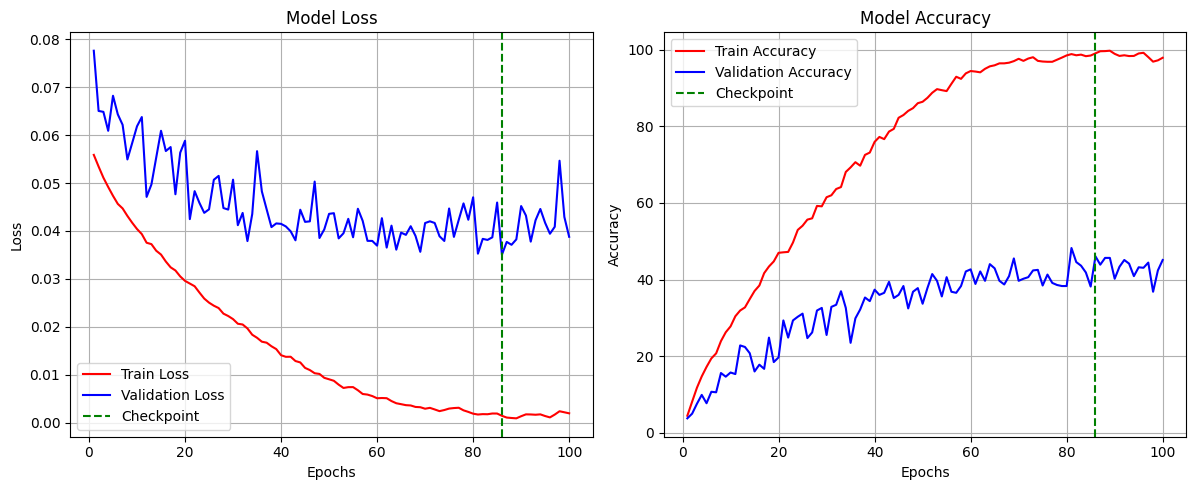

In [11]:
visualize(checkpoint_epoch, history)

# 성능 측정

In [12]:
def test(model, optimizer, loss_function, test_loader):
  # Test
  model.eval()
  loss_temp = 0.0
  accuracy_temp = 0.0
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      output = model(images)
      loss = loss_function(output, labels)

      prediction = output.argmax(dim=1)
      loss_temp += loss.item()
      accuracy_temp += torch.sum(prediction == labels)

  test_loss = loss_temp / len(test_loader.sampler)
  test_accuracy = accuracy_temp.cpu() / len(test_loader.sampler) * 100

  print(f"Test Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.4f}%")

In [13]:
test(model, optimizer, loss_function, test_loader)

Test Loss: 0.0454, 	Test Accuracy: 37.9667%


## 분석 및 고찰

- Oxford-IIIT Pet 특징
  - Oxford-IIIT Pet 데이터셋은 총 37개의 클래스를 가지고 있으며 각 클래스마다 200개의 라벨링된 학습 데이터를 제공
  - Oxford-IIIT Pet 데이터셋은 이미지의 크기가 일정하지 않고 모두 달라 CNN 모델에 입력하기 위해서는 전처리가 필요

- 적용한 학습 기법
  - Early Stopping

    학습 과정에서 Validation Loss가 일정 Epoch 동안 개선되지 않을 경우 학습을 조기에 중단하도록 구현

  - Weight Dacay

    모델의 가중치에 대한 정규화를 적용하여 Overfitting을 방지

  - Dropout

    학습 과정에서 무작위 뉴런을 비활성화하여 Bagging과 유사한 효과를 부여

  - Model Checkpoint

    학습 과정에서 Validation Loss가 가장 낮았던 상태의 모델 가중치를 저장하고 갱신하면서 최종 학습이 끝난 후 그 상태를 모델에 적용


- 어려웠던 점 / 한계
  - 입력 이미지의 크기가 모두 다르기 때문에 통일시킬 수 있는 적절한 크기를 찾는 부분이 어려웠음
  - 입력 이미지가 작으면 데이터 손실이 많았고, 입력 이미지가 크면 학습에 오랜 시간이 걸렸음
  - 입력 이미지의 크기와 비율이 모두 달랐기 때문에 하나의 크기로 통일시키는 과정에서 기존 이미지의 비율이 변형되는 경우가 많았음
  - 이를 해결하기 위해 비율을 유지하면서 Padding을 채우거나, CenterCrop을 하는 방법도 고민해봤으나, 이미지의 비율이 변형됨에 따라 생기는 Data Augmentation 효과를 기대하고 비율을 변형하면서 고정 크기로 변형하는 방식을 채택함
  - 모델 자체가 가변 이미지 크기를 입력받을 수 있도록 구현하는 시도도 있었으나, 이 경우 Batch 처리가 불가능하고 복잡해지는 관계로 입력 이미지를 고정 크기로 변환하는 방식을 채택함